# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting
import seaborn as sns
import numpy as np ### math computations
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, Resizing, Rescaling #for augmentation
                                     )
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from sklearn.metrics import confusion_matrix, roc_curve,f1_score

from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

import cv2
import albumentations as A

In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualizing

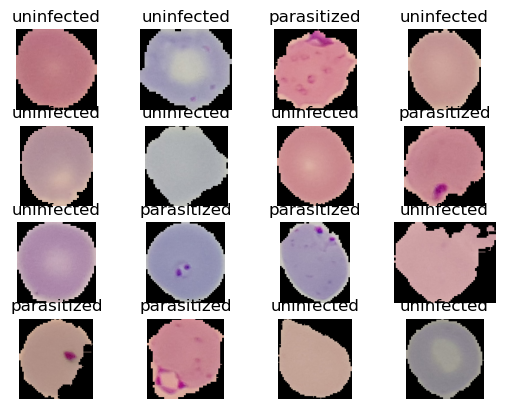

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
 dataset_info.features['label'].int2str(0)

'parasitized'

# Augmentation

In [10]:
IM_SIZE = 224

## Albumentations 

In [11]:
transforms = A.Compose([
            A.Resize(IM_SIZE, IM_SIZE),
            A.OneOf([A.HorizontalFlip(),
                     A.VerticalFlip()]),
            A.RandomRotate90(),
            #A.RandomGridShuffle(grid=(3,3), always_apply=False, p = 0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, always_apply=False, p = 0.5),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0),  always_apply=False, p = 0.5)
            
        ])

In [12]:
def aug_albument(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return aug_img

In [13]:
def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_albument, inp=[image], Tout=tf.float32)
    return aug_img, label

# Data Preprocessing

In [14]:
BATCH_SIZE = 32
train_dataset = (train_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 .map(process_data) # augmentation with Albumentation
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                .map(process_data) # augmentation with Albumentation
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

#test_dataset = test_dataset.map(resizing_rescaling_layers)

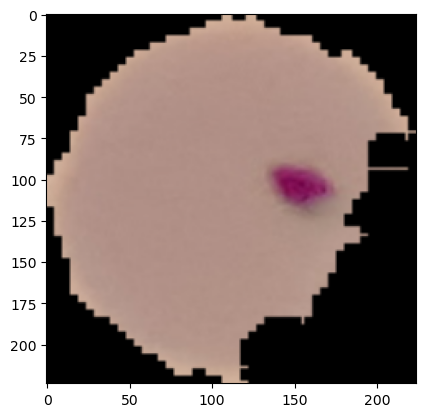

In [15]:
im, _ = next(iter(train_dataset))
plt.imshow(im[0])

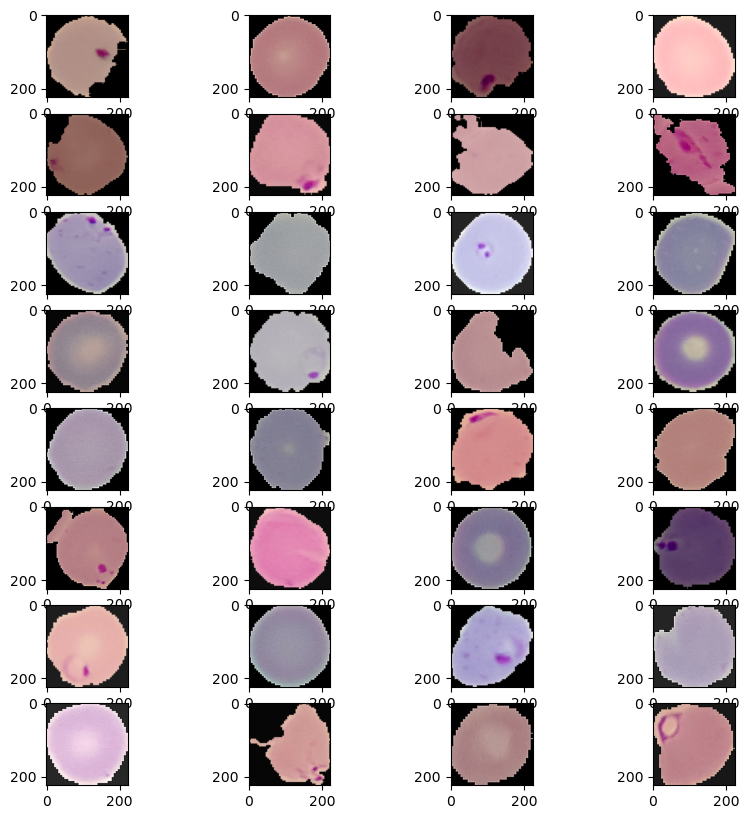

In [16]:
plt.figure(figsize=(10, 10))
for i in range(32):
    plt.subplot(8, 4, i+1)
    plt.imshow(im[i])

# BuildModel 

In [17]:
sequential_model = tf.keras.Sequential([
    InputLayer(input_shape= (IM_SIZE, IM_SIZE,3)),
    
    Conv2D(filters= 8,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
           
    Conv2D(filters= 16,kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2),
           
    Flatten(),
           
    Dense(units=100, activation='relu'),
    BatchNormalization(),
    
    Dense(units=10, activation='relu'),
    BatchNormalization(),
    
    Dense(units=1, activation='sigmoid') 
])
sequential_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Optimizers

In [18]:
metrics = [TruePositives(name='tp'), FalsePositives(name= 'fp'), FalseNegatives(name= 'fn'), TrueNegatives(name='tn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# Compile

In [19]:
sequential_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics= metrics,)

# Train

In [20]:
history = sequential_model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
689/689 [==============================] - 36s 49ms/step - loss: 0.4192 - tp: 9398.0000 - fp: 2455.0000 - fn: 1625.0000 - tn: 8568.0000 - accuracy: 0.8149 - precision: 0.7929 - recall: 0.8526 - auc: 0.8921 - val_loss: 0.3623 - val_tp: 1269.0000 - val_fp: 59.0000 - val_fn: 122.0000 - val_tn: 1305.0000 - val_accuracy: 0.9343 - val_precision: 0.9556 - val_recall: 0.9123 - val_auc: 0.9630
Epoch 2/10
689/689 [==============================] - 34s 50ms/step - loss: 0.2660 - tp: 10310.0000 - fp: 1098.0000 - fn: 715.0000 - tn: 9923.0000 - accuracy: 0.9178 - precision: 0.9038 - recall: 0.9351 - auc: 0.9478 - val_loss: 4.3505 - val_tp: 1.0000 - val_fp: 2.0000 - val_fn: 1387.0000 - val_tn: 1365.0000 - val_accuracy: 0.4958 - val_precision: 0.3333 - val_recall: 7.2046e-04 - val_auc: 0.9536
Epoch 3/10
689/689 [==============================] - 35s 51ms/step - loss: 0.2539 - tp: 10372.0000 - fp: 1120.0000 - fn: 654.0000 - tn: 9900.0000 - accuracy: 0.9195 - precision: 0.9025 - recall: 0.940

# Loss

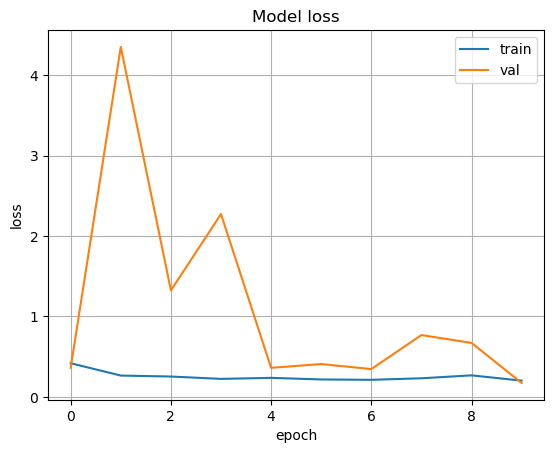

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

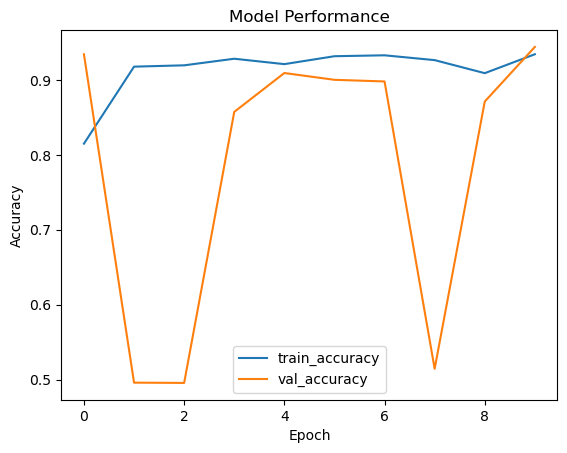

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [23]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

In [24]:
test_dataset2 = test_dataset.map(resize_rescale).batch(1)

In [25]:
evals = sequential_model.evaluate(test_dataset2, return_dict = True)
evals

2757/2757 [==============================] - 8s 3ms/step - loss: 0.1890 - tp: 1304.0000 - fp: 124.0000 - fn: 59.0000 - tn: 1270.0000 - accuracy: 0.9336 - precision: 0.9132 - recall: 0.9567 - auc: 0.9741


{'loss': 0.1890302449464798,
 'tp': 1304.0,
 'fp': 124.0,
 'fn': 59.0,
 'tn': 1270.0,
 'accuracy': 0.9336234927177429,
 'precision': 0.913165271282196,
 'recall': 0.9567131400108337,
 'auc': 0.9741058349609375}

# Predict

In [26]:
sequential_model.predict(test_dataset2.take(1))[0][0]

1/1 [==============================] - 1s 544ms/step


0.013271845

In [27]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [28]:
parasite_or_not(sequential_model.predict(test_dataset2.take(1))[0][0])

1/1 [==============================] - 1s 502ms/step


'U'

1/1 [==============================] - 0s 11ms/step


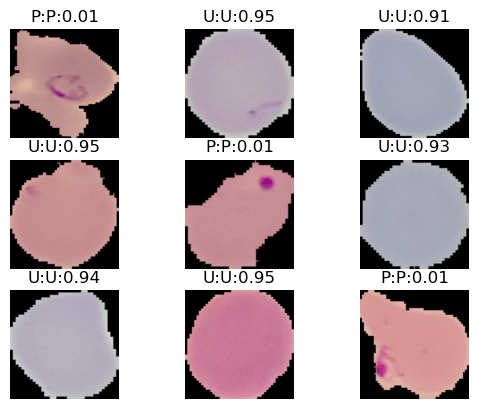

In [29]:
for i, (image, label) in enumerate(test_dataset2.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  res = sequential_model.predict(image)[0][0]
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
  plt.axis('off')

In [30]:
test_dataset2.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Visualising Confusion Matrix

In [31]:
inps = []
labels = []
for _,(x,y) in enumerate(test_dataset2):
    labels.append(y)
    inps.append(x)

In [32]:
labels[:5]

[<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>]

In [33]:
labels = np.array([i.numpy()[0] for i in labels])
print(labels)

[0 1 0 ... 1 1 0]


In [34]:
np.array(inps[0]).shape

(1, 224, 224, 3)

In [35]:
predicted = [sequential_model.predict(i) for i in inps ] #np.array(inps)[:,0,...])
len(predicted)

1/1 [==============================] - 0s 11ms/step


2757

In [36]:
pred_labels = np.squeeze(predicted)
pred_labels.shape

(2757,)

In [37]:
threshold = 0.5

cm = confusion_matrix(labels, pred_labels > threshold)
print(cm)

[[1267  124]
 [  59 1307]]


Text(0.5, 58.7222222222222, 'Predicted')

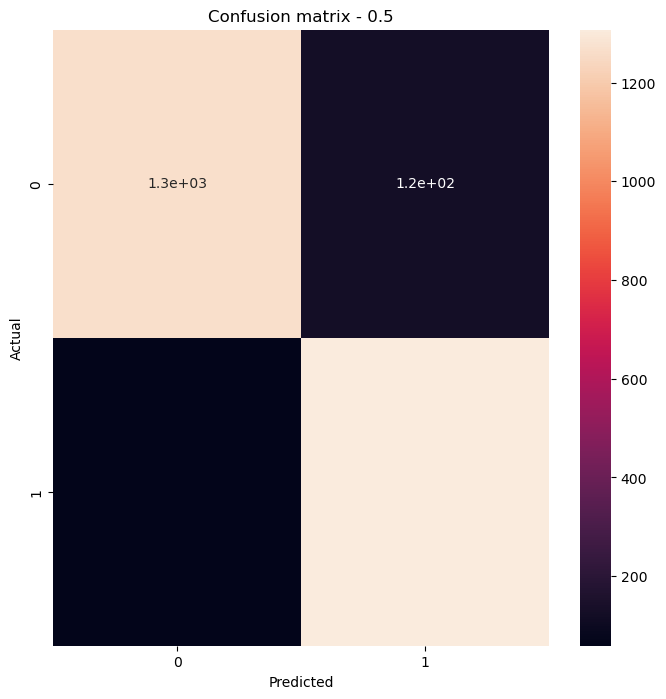

In [38]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

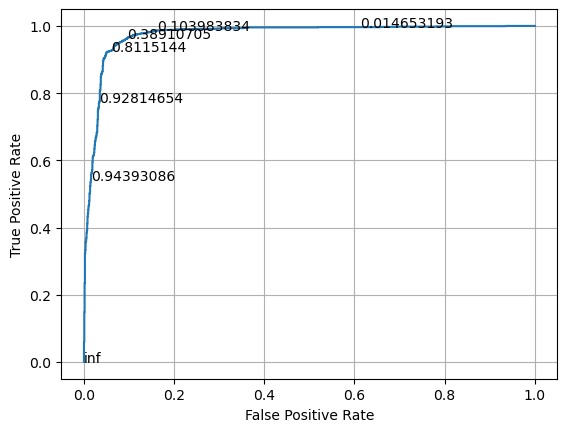

In [39]:
fp, tp ,threshoulds = roc_curve(labels, pred_labels)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(threshoulds), skip):
    plt.text(fp[i], tp[i], threshoulds[i])
plt.show()

In [40]:
f1 = f1_score(y_true= labels, y_pred= np.round(pred_labels))
f1

0.9345727565248481